In [1]:
import os,sys,string, time
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
from importlib import reload

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Variables_bins as Variables_bins
import Utilities.Functions as Functions
import Utilities.Sys_unc_variables as Sys_unc
from Utilities.ipython_exit import exit

print ('Success')


Success


# Reading in .pkl files

In [2]:
Params = {"Run":"run3", #The run number, so far either "run1" or "run3"
          "Load_single_file":False, #This will override everything else, put the desired file in the "single_file" line
          "single_file":"overlay",
          "Load_standard_bkgs":True,
          "Load_DetVars":False, #overlay DetVar samples
          "Only_keep_common_DetVar_evs":True, #Removes events not in all DetVar samples
          "Load_Signal_DetVars":False, #ee DetVar samples
          "Load_data":True,
          "FLATTEN":False, #Have one row per reconstructed object in the analysis dataframe
          "only_presel":True, #Create small files containing only variables necessary for pre-selection, for making pre-selection plots
          "Load_truth_vars":False, 
          "Load_lepton_signal":True,
          "Load_lepton_dirac":False,
          'Load_pi0_signal_DetVars':False, #pi0 DetVar samples
          "Load_pi0_signal":False,
          "Load_pi0_dirac":False}

# Params, samples = Functions.create_sample_list(Params)
Params, samples = Functions.new_create_sample_list(Params)
loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/"+Params["variables_string"]+"/"

Loading these run3 samples: 
['overlay', 'dirtoverlay', 'beamoff', 'beamgood', '2_ee', '10_ee', '20_ee', '50_ee', '100_ee', '150_ee']


In [3]:
samples_dict = Functions.Load_initial_pkls(samples, Params, loc_pkls, "_full_Finished")

for sample in samples_dict:
    print(f"{sample} length is " + str(len(samples_dict[sample])))
print("Loading these variables:")
print(samples_dict[sample].keys())

overlay length is 748702
dirtoverlay length is 389264
beamoff length is 3211097
beamgood length is 1104349
2_ee length is 45159
10_ee length is 44463
20_ee length is 46022
50_ee length is 44579
100_ee length is 45304
150_ee length is 44031
Loading these variables:
Index(['nslice', 'flash_time', 'nu_flashmatch_score', 'NeutrinoEnergy2',
       'contained_fraction', 'trk_score', 'trk_score_v', 'n_pfps',
       'topological_score', 'swtrig_pre', 'swtrig_post', 'crtveto', 'run',
       'sub', 'evt', 'rse_id'],
      dtype='object')


## Applying Software Trigger

In [4]:
def Apply_swtrig(df):
    query="swtrig_pre>0"
    df.query(query)
    
def Apply_swtrig_run2_beamoff(df):
    query="swtrig>0"
    df.query(query)

def Apply_flash_shift(df, sample_type):
    #Only required for beam off, overlay, dirtoverlay and signal (i.e all except beamon data)
    if(sample_type=="beamoff"): df["flash_time"]=df["flash_time"] -0.359
    else: df["flash_time"]=df["flash_time"] - 0.304
    
Pre_swtrig_dict = {}
swtrig = {}

apply_swtrig = True

if(apply_swtrig): print("Applying software trigger!")

for sample in samples_dict:
    print(sample)
    Pre_swtrig_dict[sample] = len(samples_dict[sample]) #Should weight this properly, i.e take sum of weights for the total number.
    if(apply_swtrig):

        if Params["Run"]=="run1":
            swtrig[sample] = samples_dict[sample].query("swtrig_pre>0").copy()
        elif Params["Run"]=="run3":
            swtrig[sample] = samples_dict[sample].query("swtrig_post>0").copy() #Took this from Owen's code, should check exactly what it's doing
        elif ((Params["Run"]=="run2a") or (Params["Run"]=="run2b")) and ((sample=="beamoff")or(sample=="beamgood")):
            swtrig[sample] = samples_dict[sample].query("swtrig>0").copy()
        else: 
            swtrig[sample] = samples_dict[sample].query("swtrig_pre>0").copy()
            
    else: swtrig[sample] = samples_dict[sample].copy()
    
    if sample != "beamgood":
        Apply_flash_shift(swtrig[sample], sample)
        
for sample in samples_dict:
    swtrig_effic = 100*(len(swtrig[sample])/Pre_swtrig_dict[sample])
    print(f"{sample} efficiency is " + str(swtrig_effic) + "%")
    
print(swtrig.keys())

Applying software trigger!
overlay
dirtoverlay
beamoff
beamgood
2_ee
10_ee
20_ee
50_ee
100_ee
150_ee
overlay efficiency is 82.60255749283426%
dirtoverlay efficiency is 80.12454272678696%
beamoff efficiency is 100.0%
beamgood efficiency is 100.0%
2_ee efficiency is 100.0%
10_ee efficiency is 100.0%
20_ee efficiency is 100.0%
50_ee efficiency is 100.0%
100_ee efficiency is 100.0%
150_ee efficiency is 100.0%
dict_keys(['overlay', 'dirtoverlay', 'beamoff', 'beamgood', '2_ee', '10_ee', '20_ee', '50_ee', '100_ee', '150_ee'])


# Plotting variables before preselection

In [5]:
#Want to have arrows drawn on for where the preselection cut goes
HNL_mass = "100_ee"
if Params["Load_pi0_signal"]:
    HNL_mass = f"{HNL_mass}_pi0" #only plotting one at a time
variable = 'topological_score'

if (Params["Run"]=="run2a") or (Params["Run"]=="run2b"):
    swtrig[HNL_mass]=swtrig["overlay"].copy()

samples_plotting = {"overlay":swtrig["overlay"],
                    "dirtoverlay":swtrig["dirtoverlay"],
                    "beamoff":swtrig["beamoff"],
                    "signal":swtrig[HNL_mass]}

if Params["Run"] == "run1":
    sample_norms = {"overlay":Constants.run1_POT_scaling_dict["overlay"], #WAS using SF_overlay_run1
                    "dirtoverlay":Constants.run1_POT_scaling_dict["dirtoverlay"],
                    "beamoff":Constants.run1_POT_scaling_dict["beamoff"],
                    "signal":Constants.run1_POT_scaling_dict[HNL_mass]}
    flat_sys_vars_dict = Sys_unc.run1_Sys_unc
elif Params["Run"] == "run3":
    sample_norms = {"overlay":Constants.run3_POT_scaling_dict["overlay"],
                    "dirtoverlay":Constants.run3_POT_scaling_dict["dirtoverlay"],
                    "beamoff":Constants.run3_POT_scaling_dict["beamoff"],
                    "signal":Constants.run3_POT_scaling_dict[HNL_mass]}
    flat_sys_vars_dict = Sys_unc.run3_Sys_unc
    
elif Params["Run"] == "run2a":
    sample_norms = {"overlay":Constants.run2a_POT_scaling_dict["overlay"],
                    "dirtoverlay":Constants.run2a_POT_scaling_dict["dirtoverlay"],
                    "beamoff":Constants.run2a_POT_scaling_dict["beamoff"],
                    "signal":Constants.run2a_POT_scaling_dict[HNL_mass]}
    flat_sys_vars_dict = Sys_unc.run3_Sys_unc
    
elif Params["Run"] == "run2b":
    sample_norms = {"overlay":Constants.run2b_POT_scaling_dict["overlay"],
                    "dirtoverlay":Constants.run2b_POT_scaling_dict["dirtoverlay"],
                    "beamoff":Constants.run2b_POT_scaling_dict["beamoff"],
                    "signal":Constants.run2b_POT_scaling_dict[HNL_mass]}
    flat_sys_vars_dict = Sys_unc.run3_Sys_unc

if Params["Load_data"] == True:
    data_dict = {"beamgood":samples_dict["beamgood"]}
    data_norm = {"beamgood":1.0} #No scaling as this is data, should have scaled MC to this POT.
    samples_plotting.update(data_dict)
    sample_norms.update(data_norm)
    
# PT.HNL_scaling_calculator(samples_plotting,sample_norms)


In [6]:
for sample in samples_plotting:
    print(sample)
    
# print(Constants.Preselection_dict_for_plot)
print(Constants.Preselection_dict)

overlay
dirtoverlay
beamoff
signal
beamgood
{'nslice': 'nslice==1', 'flash_time': 'flash_time > 6.25 and flash_time < 16.5', 'nu_flashmatch_score': 'nu_flashmatch_score < 15', 'NeutrinoEnergy2': 'NeutrinoEnergy2 < 500', 'Fiducial_cut': 'min_y>-112 and max_y<112 and min_z>14 and max_z<1020 and min_x>9 and max_x<253', 'contained_fraction': 'contained_fraction > 0.9'}


## Plot data and MC

In [7]:
samples_plotting["overlay"].keys()

Index(['nslice', 'flash_time', 'nu_flashmatch_score', 'NeutrinoEnergy2',
       'contained_fraction', 'trk_score', 'trk_score_v', 'n_pfps',
       'topological_score', 'swtrig_pre', 'swtrig_post', 'crtveto',
       'weightSplineTimesTune', 'ppfx_cv', 'npi0', 'run', 'sub', 'evt',
       'weight', 'rse_id'],
      dtype='object')

In [25]:
#Calculate sys
Calculate_sys = True
variable = 'contained_fraction'

reload(PT)
reload(Functions)
reload(Constants)
reload(Sys_unc)
reload(Variables_bins)

if Params["Run"] == "run1": 
    flat_sys_vars_dict = Sys_unc.run1_Sys_unc
    PLOTSCALE = 240000000
    arrow_place = Variables_bins.arrow_places[variable]
if Params["Run"] == "run3": 
    flat_sys_vars_dict = Sys_unc.run3_Sys_unc
    PLOTSCALE = 200000000
    arrow_place = Variables_bins.arrow_places_r3[variable]

    
if isinstance(Constants.variable_names_dict[variable],str):x_string = Constants.variable_names_dict[variable]
else: x_string=variable
if variable=='trk_score_v':ylabel = 'Reconstructed objects'
else: ylabel='Events'
if variable=='nslice':xticks=[0,1]
else: xticks=[]

if (variable.startswith('min')) or (variable.startswith('max')):
    dropdupes=True
    print("Only keeping one entry per event for this plot!")
else: dropdupes=False

BINS = Variables_bins.Presel_bins[variable]
XLIMS = [BINS[0],BINS[-1]]

Log_var = Variables_bins.Log_vars[variable]
cut_line = Variables_bins.cut_lines[variable]
# arrow_place = Variables_bins.arrow_places[variable]
# arrow_place = []
print("Arrow place is " + str(arrow_place))

Name = ""
if Params["Load_pi0_signal"] == True: Name = "pi0/"
if Calculate_sys==True: Sys_name = "with_sys"
if Calculate_sys==False: Sys_name = "no_sys"
if arrow_place != []: end_name = "_arrow"
else: end_name = ""

if Params["Run"]=="run1": Run = "Run 1"
if Params["Run"]=="run3": Run = "Run 3"

Arrow place is [0.9, 650000.0, 0.95, 650000.0]


Plotting contained_fraction for run3
nbins 10


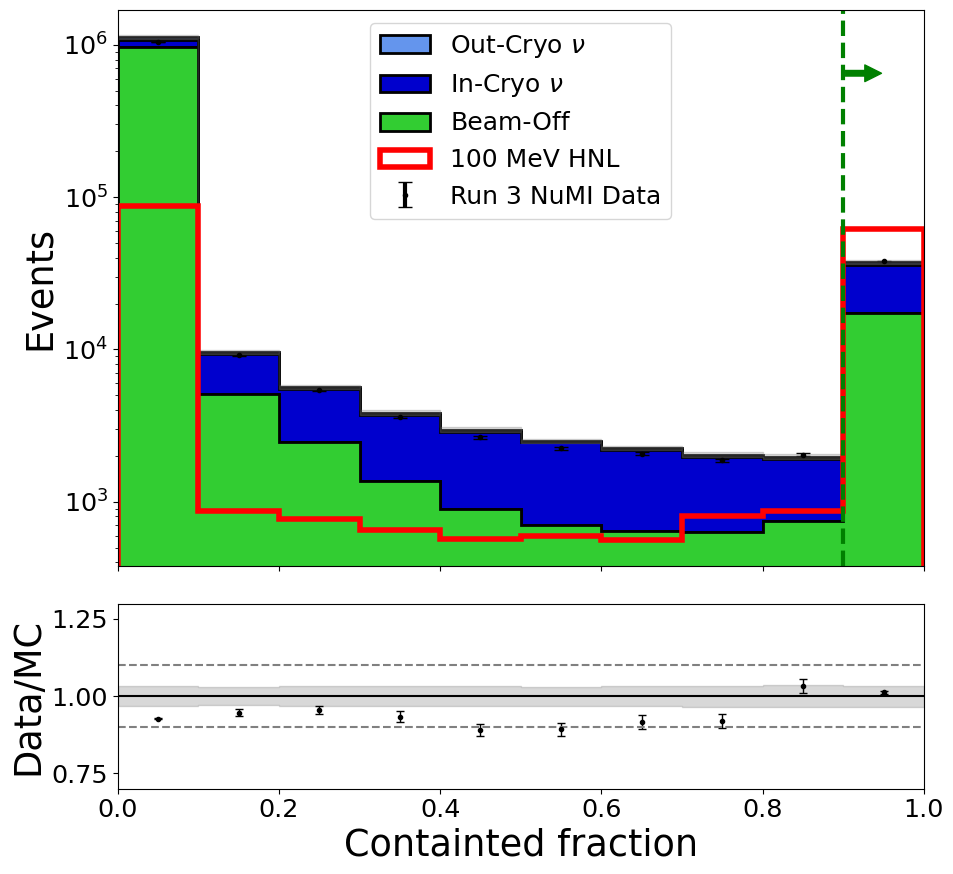

In [27]:
savefig=True

print(f"Plotting {variable} for " + Params["Run"])

# bins_test = [0,25.0]
bins_test = BINS
print("nbins " + str(len(bins_test)-1))

PT.Plot_preselection_variable_data(variable, samples_plotting, sample_norms, xlabel=x_string, xlims=XLIMS, bins=bins_test, HNL_mass=100,
                                   HNLplotscale=PLOTSCALE, cutline=cut_line, legloc="best", show_ev_nums=False, CalcSys=Calculate_sys, logy=Log_var, 
                                   xticks=xticks, sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel=ylabel, 
                                   arrow_place=arrow_place, ylimit=None, legsize=18, dropdupes=dropdupes, err_print=False, Run=Run, chi_squared=False, 
                                   dirt_frac_error=0.75)

# plt.ylim([1, 3e4])

if savefig == True:
    plt.savefig(f"plots/Data_MC_comparison/{Name}Presel_{variable}_" + Params["Run"] + f"_{HNL_mass}_{Sys_name}{end_name}.png")
    plt.savefig(f"plots/Data_MC_comparison/{Name}Presel_{variable}_" + Params["Run"] + f"_{HNL_mass}_{Sys_name}{end_name}.pdf")

## Plotting only highest E object

In [ ]:
Highest_E_placeholder = Functions.only_keep_highest_E(samples_dict[HNL_mass])

samples_plotting = {"overlay":samples_dict["overlay"],
           "dirtoverlay":samples_dict["dirtoverlay"],
           "beamoff":samples_dict["beamoff"],
           "signal":Highest_E_placeholder}

PT.Plot_preselection_variable(variable, samples_plotting, sample_norms, xlabel=[],xlims=[1,100],bins=100, HNL_mass=HNL_mass,
                              HNLplotscale=600000,cutline=0.0,legloc="upper right")

plt.savefig("plots/Preselection_variables/" + Params["Run"] + "_" + str(HNL_mass) + "_MeV_" + str(variable)+"_highest_E.png")

## Plot only signal samples before preselection

In [ ]:
#Need a new plotting function for this
reload(Constants)

# Plotting significance of individual cuts

In [ ]:
# cut_start_str = "flash_time > 16.5"
reload(Functions)
cut_start_str = "min_z > "

variable = "min_z"

Sig_dict_max, Sig_dict_min, var_sig_max, var_sig_min = Functions.Significance_scan(Params, swtrig, cut_start_str, 0, 40, numsteps=20)

PT.Plot_significance_scan(variable, Sig_dict_max, Sig_dict_min, var_sig_max, var_sig_min)

# Pre-selection cuts

In [ ]:
Use_tight_presel=False

if Params["FLATTEN"] == True: Preselection_dict = Constants.Preselection_dict 
else: Preselection_dict = Constants.Preselection_dict_for_plot

if Use_tight_presel == True: Preselection_dict = Constants.Tight_Preselection_dict
        
if Params["Run"] == "run3": Preselection_dict.update(Constants.Preselection_dict_crtveto) #Adding crtveto cut
        
if (Params["Load_DetVars"] == True) and (Params["Run"] == "run3"):
    removed=Preselection_dict.pop('Fiducial_cut')

    
# Preselection_dict.update({"topological_score":"topological_score < 0.98"})

print("Preselection is:" + "\n")
print(Preselection_dict)


In [ ]:
reload(Functions)
sample_dict_copy = {}
for sample in swtrig:
    sample_dict_copy[sample] = swtrig[sample].copy()

    
if (Params["Load_DetVars"] == True) or (Params["Load_Signal_DetVars"] == True) or (Params['Load_pi0_signal_DetVars'] == True):
    Preselected = Functions.Preselection_DetVars(sample_dict_copy, Preselection_dict)
else:
    if Params["FLATTEN"] == False:
        Efficiency_dict, Preselected = Functions.Preselection_weighted_efficiency(sample_dict_copy, Preselection_dict)
    if Params["FLATTEN"] == True:
        Efficiency_dict, Preselected = Functions.Flattened_Preselection_weighted_efficiency(sample_dict_copy, Preselection_dict, Params["Run"])
    
    print(Efficiency_dict.keys())
print("Finished pre-selection cuts.")


## Printing and plotting efficiencies

In [ ]:
Preselection_signal_min, Preselection_signal_max = Functions.Get_signal_efficiency_range(Params, Preselection_dict, Efficiency_dict)

Functions.Print_efficiency_numbers(Params, Preselected, Efficiency_dict)


In [ ]:
reload(Constants)

In [ ]:
PT.Plot_preselection_efficiency(Params, Preselection_dict, Efficiency_dict, Preselection_signal_min, Preselection_signal_max, log=True)


In [ ]:
effic_wrt_prev, lowest_signal_wrt_prev, highest_signal_wrt_prev = Functions.Get_effic_wrt_previous(Params, Preselection_dict, Efficiency_dict)

PT.Plot_effic_wrt_previous(Params, Preselection_dict, effic_wrt_prev, lowest_signal_wrt_prev, highest_signal_wrt_prev)


## Only select highest energy object and "Prepare" for xgboost

In [ ]:
trk_score_cut = True

Prepared_dict = {}
if(trk_score_cut): Preselected_dict = Functions.Remove_high_trk_score_objects(Preselected, threshold=0.97)
else: Preselected_dict = Preselected.copy()

Highest_E_placeholder = Functions.only_keep_highest_E(Preselected_dict)
# Prepared_dict = Functions.Prepare_dfs_for_xgb(Highest_E_placeholder)
Prepared_dict = Functions.Fixed_Prepare_dfs_for_xgb(Highest_E_placeholder)

print(Prepared_dict.keys())

In [ ]:
# for variable in Prepared_dict["overlay"].keys():
#     print(variable)
#     print(max(Prepared_dict["overlay"][variable]))
#     print(min(Prepared_dict["overlay"][variable]))

# Save pkls

In [ ]:
print_vals = input("Do you want to save the pickle files? y/n ")
if print_vals == "y":
    Functions.Save_preselected_pkls(Prepared_dict, Params, loc_pkls, "full_Finished")
else:
    print("Not saving pickle files, move onto next cell")

## Plotting single mass point and background

In [ ]:
#Plotting efficiency
signal_mass = 220
plt.figure(figsize=[10,10])
plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict[signal_mass],label=f"{signal_mass} MeV HNL",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict['overlay'],label="MC run1 overlay",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict['dirtoverlay'],label="MC run1 dirt",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict['beamoff'],label="MC run1 EXT",lw=4,markersize=15)
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Efficiency_dict[effic])+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
#plt.yscale("log")
plt.legend()


## Plotting just signal

In [ ]:
if Params["Load_lepton_signal"]: plotting_samples = ["10_ee","50_ee", "100_ee", "150_ee"]
if Params["Load_pi0_signal"]: plotting_samples = ["150_pi0","180_pi0","200_pi0", "245_pi0"]
sig_plot_dict = {}
for signal in plotting_samples:
    sig_plot_dict[signal] = samples_dict[signal].copy()
    sig_plot_dict[signal]=sig_plot_dict[signal].drop_duplicates(subset=["run","evt","sub"])


In [ ]:
delta_x, delta_y, delta_z = {}, {}, {}

for signal in sig_plot_dict:
    delta_x[signal] = sig_plot_dict[signal]['max_x'] - sig_plot_dict[signal]['min_x']
    delta_y[signal] = sig_plot_dict[signal]['max_y'] - sig_plot_dict[signal]['min_y']
    delta_z[signal] = sig_plot_dict[signal]['max_z'] - sig_plot_dict[signal]['min_z']
    
    sig_plot_dict[signal]["Length_x"] = delta_x[signal]
    sig_plot_dict[signal]["Length_y"] = delta_y[signal]
    sig_plot_dict[signal]["Length_z"] = delta_z[signal]

print(delta_x[signal])

#'trk_sce_start_x_v', 'trk_sce_start_y_v','trk_sce_start_z_v', 'trk_sce_end_x_v', 'trk_sce_end_y_v','trk_sce_end_z_v'

In [ ]:
diagonal_length_slice =  {}
for signal in sig_plot_dict:
    diagonal_length_slice[signal] = np.sqrt(delta_x[signal]**2 + delta_y[signal]**2 + delta_z[signal]**2)
    
print(diagonal_length_slice[signal])

In [ ]:
length_max_object =  {}
obj_sig_plot_dict = {}
object_delta_x, object_delta_y, object_delta_z = {}, {}, {}
delta_total = {}
for signal in sig_plot_dict:
    obj_sig_plot_dict[signal] = samples_dict[signal].copy()
    object_delta_x[signal] = abs(obj_sig_plot_dict[signal]['trk_sce_start_x_v'] - obj_sig_plot_dict[signal]['trk_sce_end_x_v'])
    object_delta_y[signal] = abs(obj_sig_plot_dict[signal]['trk_sce_start_y_v'] - obj_sig_plot_dict[signal]['trk_sce_end_y_v'])
    object_delta_z[signal] = abs(obj_sig_plot_dict[signal]['trk_sce_start_z_v'] - obj_sig_plot_dict[signal]['trk_sce_end_z_v'])
    
    obj_sig_plot_dict[signal]["obj_x_extent"] = object_delta_x[signal]
    obj_sig_plot_dict[signal]["obj_y_extent"] = object_delta_y[signal]
    obj_sig_plot_dict[signal]["obj_z_extent"] = object_delta_z[signal]
    
    delta_total[signal] = np.sqrt(obj_sig_plot_dict[signal]["obj_x_extent"]**2 + obj_sig_plot_dict[signal]["obj_y_extent"]**2 + obj_sig_plot_dict[signal]["obj_z_extent"]**2)
    
    obj_sig_plot_dict[signal]["obj_total_extent"] = delta_total[signal]
    
print(object_delta_x[signal])
print(delta_total[signal])


In [ ]:
largest_object_samples = {}

for sample in obj_sig_plot_dict:
    largest_object_samples[sample] = obj_sig_plot_dict[sample].copy()
    largest_object_samples[sample]["largest_obj"]=largest_object_samples[sample]["obj_total_extent"].groupby("entry").transform(max) == largest_object_samples[sample]["obj_total_extent"]
    largest_object_samples[sample] = largest_object_samples[sample].query("largest_obj").copy()

print(largest_object_samples[sample]["obj_total_extent"])


In [ ]:
for signal in sig_plot_dict:
    sig_plot_dict[signal]["Length_slice"] = diagonal_length_slice[signal]
    
print(sig_plot_dict[signal].keys())

In [ ]:
def Plot_variable_signal(variable, HNL_samples_dict=[], xlabel=[], xlims=[0,0], bins=40, figsize=[10,10], dpi=100, xticks=[], 
                         density=True,legloc="best",logy = False, cutline = None, savefig=False, filename=None, plot_entries=False,fraction=False):
    
    if(HNL_samples_dict==[]): raise Exception("Specify samples dict") 
    if(xlabel==[]): xlabel=variable
    
    if logy == True: logscale="log"
    elif logy == False: logscale="linear"
    
    fig,ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=figsize,dpi=dpi)
    
    for HNL_mass in HNL_samples_dict:
        
        mass_str = HNL_mass.split("_")[0]
        dec_type = HNL_mass.split("_")[1]
    
        #var_HNL=HNL_samples_dict[HNL_mass][variable] #old way when specifying variable
        var_HNL=HNL_samples_dict[HNL_mass][variable]
        Num_entries = len(var_HNL)
       
        if xlims[0] == 0 and xlims[1] == 0: xlims = [min(var_HNL),max(var_HNL)]
    
        if(isinstance(bins, int)):
            nbins=bins
            bins=np.linspace(xlims[0],xlims[1],nbins+1)
        else: nbins=len(bins)-1
    
    #plt.sca(ax[0])
               
        if plot_entries==True: label=[f"{mass_str} MeV HNL: " + str(Num_entries) + " entries"]
        if plot_entries==False: label=[f"{mass_str} MeV HNL"]
                   
        if fraction == False:
            p=plt.hist(var_HNL,
    #               label=[f"HNL ({mass} MeV) \n $|U_{{\mu4}}|^2="+sci_notation(sample_info["300"]["theta_u2"]) +f" (x{HNLplotscale})"],
                  label=label,
                  range=xlims,bins=bins,
                  stacked=False,density=density,
                  histtype="step",lw=3)
        if fraction == True:
            p=plt.hist(var_HNL,weights=np.ones(len(var_HNL)) / len(var_HNL),
                     label=label,
                  range=xlims,bins=bins,
                  stacked=False,density=False,
                  histtype="step",lw=3)
    
    if(isinstance(cutline, (int,float))):
        plt.axvline(x=cutline, lw=3, color='green', linestyle = 'dashed')
    
    if(logy == True):
        plt.yscale("log")
    else:
        plt.yscale("linear")
        
    if(fraction == True):
        plt.ylabel("Fraction of events")
        
    if dec_type == "ee": text1 = r'$N\rightarrow \nu e^{+}e^{-}$'
    if dec_type == "pi0": text1 = r'$N\rightarrow \nu \pi^{0}$'   
    
    plt.legend(loc=legloc,frameon=True, fontsize=18, title=text1)
    
    plt.xlabel(xlabel)
    plt.xlim(xlims)
    if xticks != []:
        plt.xticks(xticks)
    # plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.tight_layout()
    plt.yscale(logscale)
    if filename == None:
        Name = variable + "_" + Params["Run"] + "_" + dec_type
    else:
        Name = filename
    if savefig == True:
        plt.savefig("plots/Preselection_variables/Reconstruction_plots/" + Name + ".png")
        plt.savefig("plots/Preselection_variables/Reconstruction_plots/" + Name + ".pdf")

In [ ]:
# 'Length_slice','Length_x', 'Length_y', 'Length_z'
variable="Length_slice"

print(sig_plot_dict.keys())

Plot_variable_signal(variable, HNL_samples_dict=sig_plot_dict, xlabel="Extent of slice [cm]", xlims=[0,150], bins=40, figsize=[10,8], dpi=100, xticks=[], 
                         density=False,legloc="best",logy = False, cutline = None, savefig=True, filename=None, plot_entries=False,fraction=True)

In [ ]:
variable="obj_total_extent"

print(sig_plot_dict.keys())

Plot_variable_signal(variable, HNL_samples_dict=largest_object_samples, xlabel="Length of largest object [cm]", xlims=[0,100], bins=40, figsize=[10,8], dpi=100, xticks=[], 
                         density=False,legloc="best",logy = False, cutline = None, savefig=True, filename=None, plot_entries=False,fraction=True)


In [ ]:
plt.figure(figsize=[10,10])

for HNL_mass in Constants.HNL_mass_samples:
    plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict[HNL_mass],label=f"{HNL_mass} MeV HNL",lw=4,markersize=15)
    
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Efficiency_dict[effic])+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
# plt.yscale("log")
plt.legend()

plt.savefig("plots/Preselection_efficiencies/Signal_only_"+Params["Run"]+"_"+Params["Flat_state"]+".png")

# Testing code

## Making sum of weights (only for unflattened)

In [ ]:
def Sum_weights(df):
    weight = df["weight"] #Just one value per event
    sum_weights = sum(weight)
    return sum_weights

for sample in ['overlay', 'dirtoverlay']:
    sum_weights_placeholder = Sum_weights(samples_dict[sample])
    print(f"{sample} sum weights is " + str(sum_weights_placeholder))

In [ ]:
#Testing what the variables look like
variable = "dvtx_x_boundary"
def test_variables(df):
    test_signal = df[variable]
    print(type(test_signal))
    print(len(test_signal))
test_variables(df_overlay_run1)
test_variables(df_dirt_run1)
test_variables(df_EXT_run1)
test_variables(df_signal_run1)

In [ ]:
#print(overlay_from_pkl['nslice'])
#print("Flat Overlay .pkl is "+str(len(FLAT_overlay_from_pkl))+" entries long.")

print("-----Unflattened-----")
unique_var = overlay_from_pkl["nslice"].unique()
print(unique_var)
unique_var = overlay_from_pkl["n_pfps"].unique()
print(unique_var)
print(overlay_from_pkl["n_pfps"])
print(type(overlay_from_pkl["n_pfps"][0]))

# for var in overlay_from_pkl.keys():
#     if type(overlay_from_pkl[var][1]) == "numpy.ndarray":
#         print(var)

# print("-----Flattened-----")
# unique_var = FLAT_overlay_from_pkl["nslice"].unique()
# print(unique_var)
# unique_var = FLAT_overlay_from_pkl["n_pfps"].unique()
# print(unique_var)
# print(FLAT_overlay_from_pkl["n_pfps"])
# print(type(FLAT_overlay_from_pkl["n_pfps"]))

## Depracated code